In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import Tracking_Py
import random

In [2]:
def load_data(common_filepath, piv_file):
    
    with h5py.File(common_filepath+"U_avg.h5", "r") as file:    
        U = file["matrix"][:]
    with h5py.File(common_filepath+"V_avg.h5", "r") as file:    
        V = file["matrix"][:]
    # with h5py.File(common_filepath+"M_avg.h5", "r") as file:    
    #     M = file["matrix"][:]
    
    with h5py.File(piv_file, "r") as file:  
        # xgrid and ygrid data the same from original PIV results. 
        xgrid = file["xgrid"][:]
        ygrid = file["ygrid"][:]
    return U, V, xgrid, ygrid 

In [3]:
U_control, V_control, xgrid_control, ygrid_control = load_data("F:/PhD_Franziska/Headon/memGFP/memGFP_control/PIV_temperal_sliding_window(window_size=5)/", 
                                                                 "F:/PhD_Franziska/Headon/memGFP/memGFP_control/memGFP_control_PIV.h5")
U_DAPT, V_DAPT, xgrid_DAPT, ygrid_DAPT = load_data("F:/PhD_Franziska/Headon/memGFP/memGFP_DAPT/time_avg(window_size=5)/", 
                                                   "F:/PhD_Franziska/Headon/memGFP/memGFP_DAPT/memGFP_DAPT_PIV.h5")
U_RA, V_RA, xgrid_RA, ygrid_RA = load_data("F:/PhD_Franziska/Headon/memGFP/memGFP_RA/time_avg(window_size=5)/", 
                                                   "F:/PhD_Franziska/Headon/memGFP/memGFP_RA/memGFP_RA_PIV.h5")

In [31]:
# plt.quiver(xgrid_control[30], ygrid_control[30], U_control[30], -V_control[30])
# plt.gca().invert_yaxis()

# Pseudo Tracks on the whole image with random start points. 

Has the advantage that the tracks are not in one limited region of aggregates/vector fields. Allow more complete tracking and therefore less error with tracks (especially long tracks)

In [24]:
def whole_image_pseudo_trajectories(U, V, start_number, t0, t1, PIV_step):
    # Generate pseudo_trajectories for the whole image based on PIV results. 
    
    # Random starting points and the time. 
    start_x_array = [[random.randint(0,1000)] for i in range(start_number)]
    start_y_array = [[random.randint(0,1000)] for i in range(start_number)]

    t_array = [[t0, t1]]*len(start_x_array)
    
    # x and y coordinates of pseudo trajectories. 
    whole_img_x, whole_img_y = Tracking_Py.pseudo_tracking_piv_grid_v2(U, V, t_array,
                                                                  start_x_array,
                                                                  start_y_array, PIV_step)

    # Plotting. 
    plt.figure(figsize=(5,5), dpi=300)
    for i in range(len(start_x_array)): 
        plt.scatter(start_x_array[i], start_y_array[i], color = "orange", s=4)
        plt.plot(whole_img_x[i], whole_img_y[i], color = "royalblue", alpha=0.5)
    plt.gca().invert_yaxis()
    plt.show()

    return whole_img_x, whole_img_y  # (start_number, time_points_number) dimensional numpy array. 

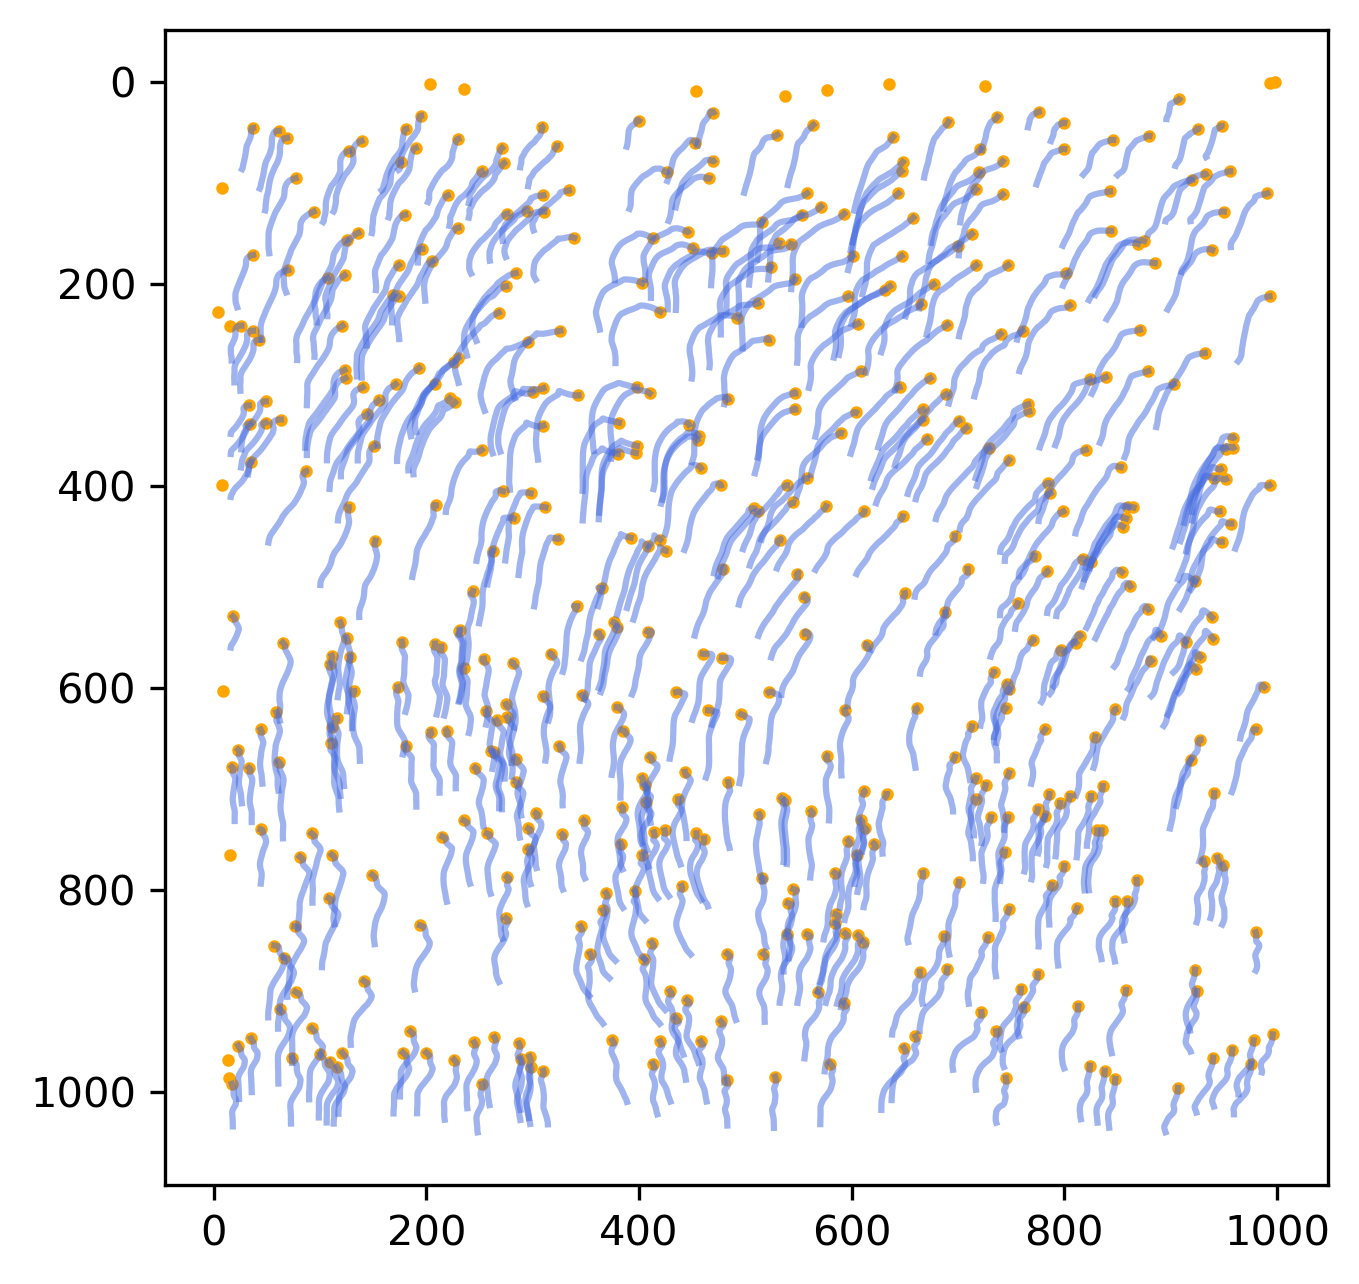

In [32]:
x_coords_control,y_coords_control = whole_image_pseudo_trajectories(U_control, V_control, 500, 0, 38, 32)

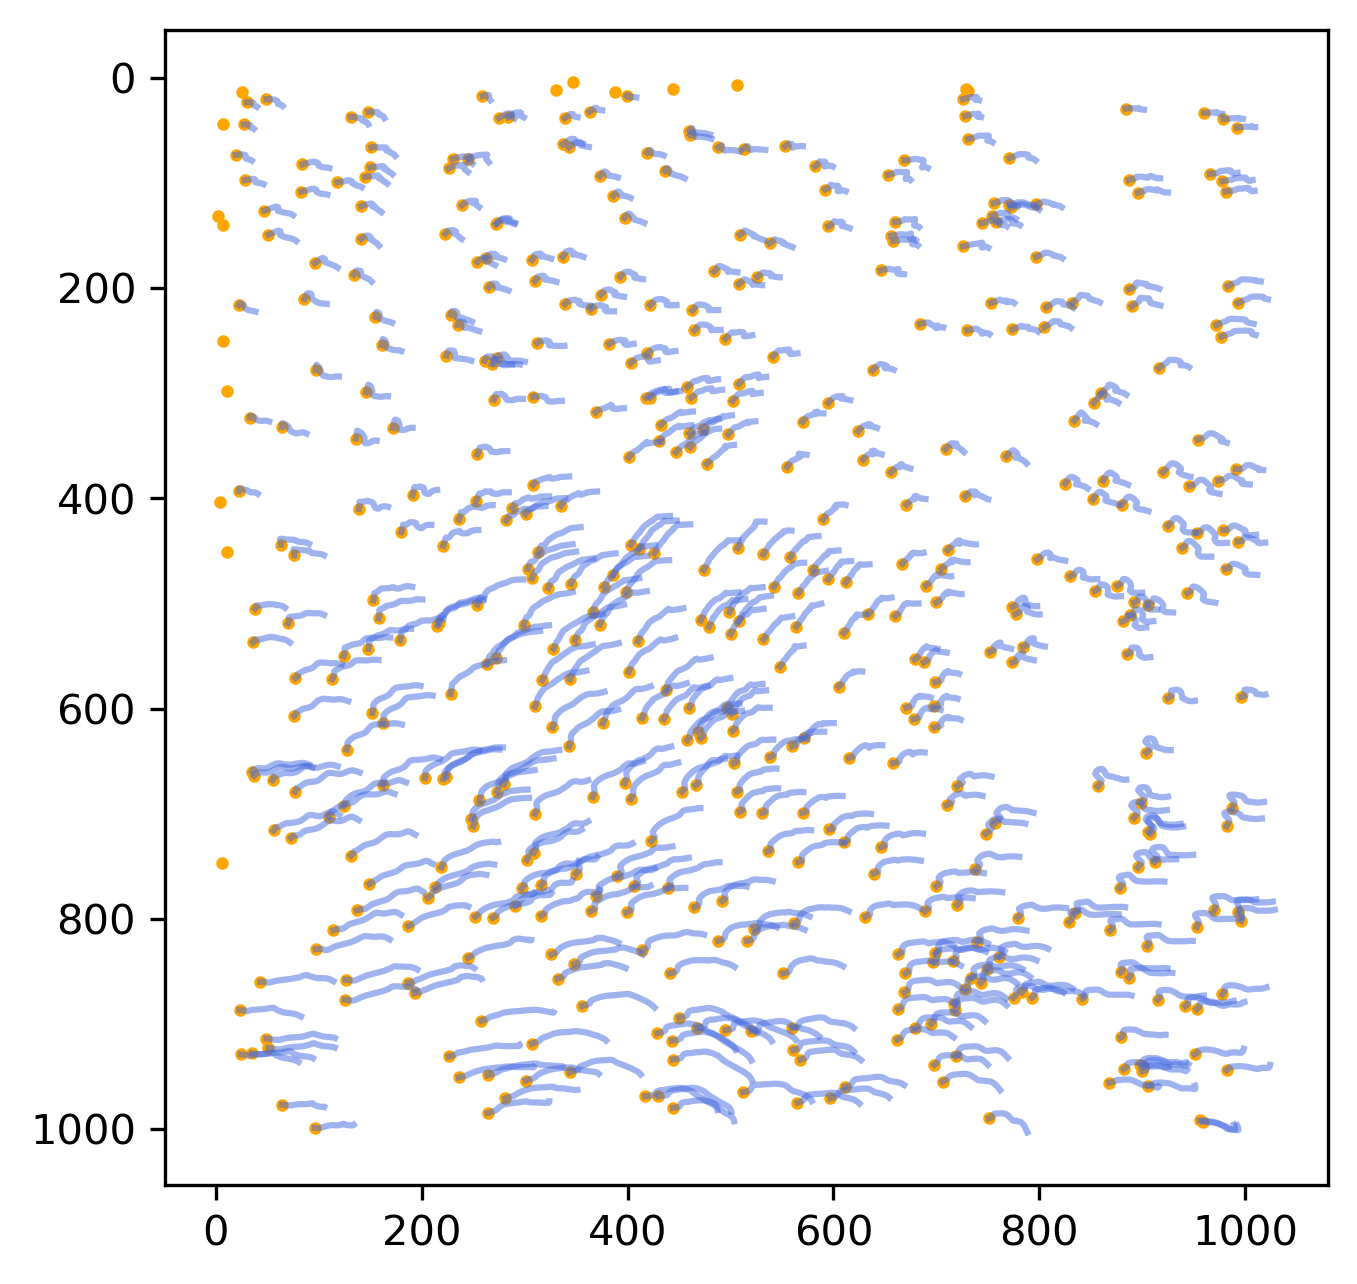

In [33]:
x_coords_DAPT, y_coords_DAPT = whole_image_pseudo_trajectories(U_DAPT, V_DAPT, 500, 0, 38, 32)

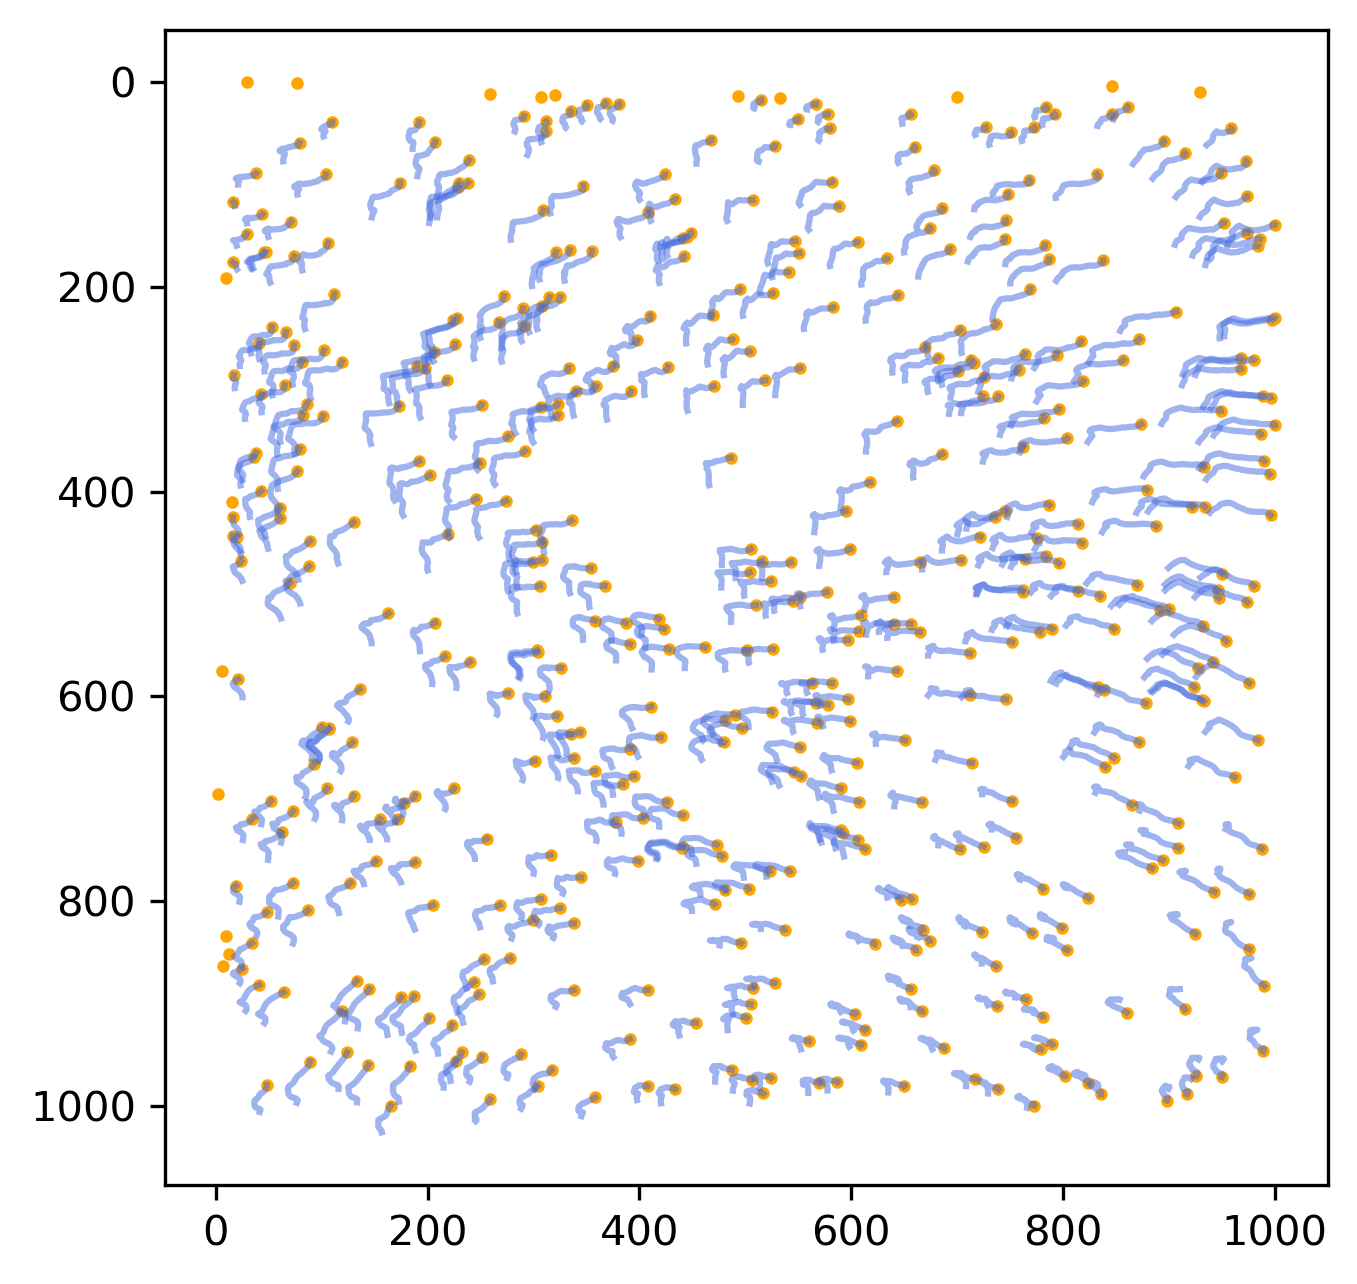

In [34]:
x_coords_RA, y_coords_RA = whole_image_pseudo_trajectories(U_RA, V_RA, 500, 0, 38, 32)

# Pseudo Tracks Analysis 
Measurement conversion: time between frames: 10 min, 1 pixel length/width = 0.69 μm. 
1. Speed (μm/min): The track length devided by the time
2. Euclidean distance: The Euclidean distance between start and end points for each track.
3. Persistence: Euclidean distance divided by the total distance travelled by the cell.

In [50]:
# The Euclidean distance between strat and end points for each pseudo trajectory.
# Without considering the measure conversion -- in pixel. 

def calculate_start_end_distance_pixel(x, y):
    # Calculate the Euclidean distance between the start and end points
    start_x, end_x = x[0], x[-1]
    start_y, end_y = y[0], y[-1]
    distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
    return distance

In [51]:
# Calculate the track length for each pseudo trajectories. 
# Without considering the measure conversion -- in pixel.

def calculate_trajectory_length_pixel(x, y):
    # Calculate the differences between consecutive points
    dx = np.diff(x)
    dy = np.diff(y)
    # Calculate the Euclidean distance for each segment and sum them
    length = np.sum(np.sqrt(dx**2 + dy**2))
    return length

### Speed

In [52]:
# Speed calculation. 

def speed_calculation(x_coords, y_coords, time_conversion, pixel_conversion): 

    # Calculate the total time for trajectory. 
    frame_number = np.shape(x_coords)[1] - 1
    total_time = frame_number * time_conversion

    # Compute the length for each trajectory
    trajectory_lengths = np.array([calculate_trajectory_length_pixel(x, y) for x, y in zip(x_coords, y_coords)])
    # Take account into the measure conversion. Speed = total track length / total time
    trajectory_speed = trajectory_lengths * pixel_conversion / total_time

    return trajectory_speed

In [53]:
speed_control = speed_calculation(x_coords_control, y_coords_control, 10, 0.69)
speed_DAPT = speed_calculation(x_coords_DAPT, y_coords_DAPT, 10, 0.69)
speed_RA = speed_calculation(x_coords_RA, y_coords_RA, 10, 0.69)

Text(0, 0.5, 'speed (μm/min)')

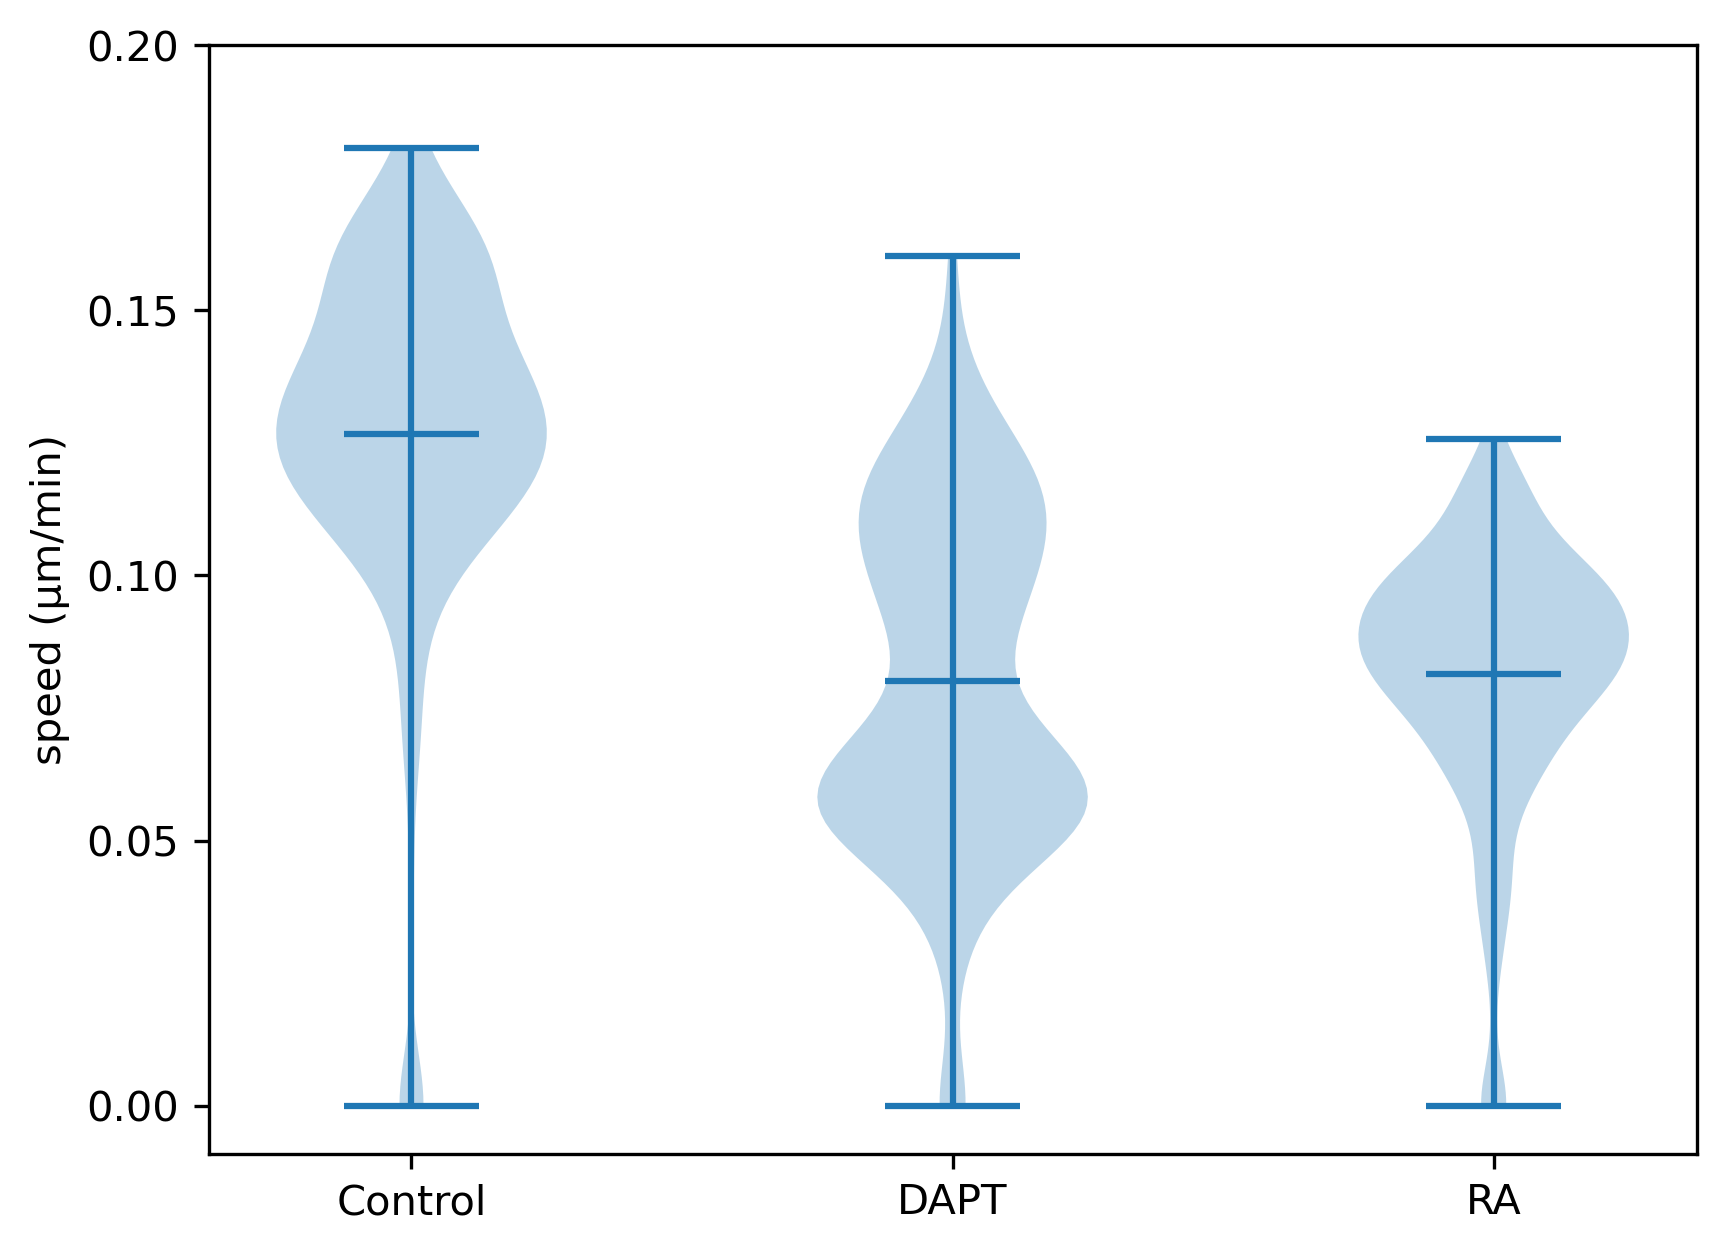

In [86]:
plt.figure(dpi=300)
plt.violinplot([speed_control, speed_DAPT, speed_RA], showmeans=True) #, showmedians=True)

# Customize the plot
plt.xticks([1, 2, 3], ["Control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 0.05, 0.1, 0.15, 0.2])
plt.ylabel("speed (μm/min)")

### Euclidean Distance

In [57]:
def euclidean_distance_calculation(x_coords, y_coords, pixel_conversion):
    # Compute the start-to-end distance for each trajectory
    start_end_distances = np.array([calculate_start_end_distance_pixel(x, y) for x, y in zip(x_coords, y_coords)])
    return pixel_conversion * start_end_distances # Take the measure conversion into account. 

In [58]:
euclidean_distance_control = euclidean_distance_calculation(x_coords_control, y_coords_control, 0.69)
euclidean_distance_DAPT = euclidean_distance_calculation(x_coords_DAPT, y_coords_DAPT, 0.69)
euclidean_distance_RA = euclidean_distance_calculation(x_coords_RA, y_coords_RA, 0.69)

Text(0, 0.5, 'Eucliean distance (μm)')

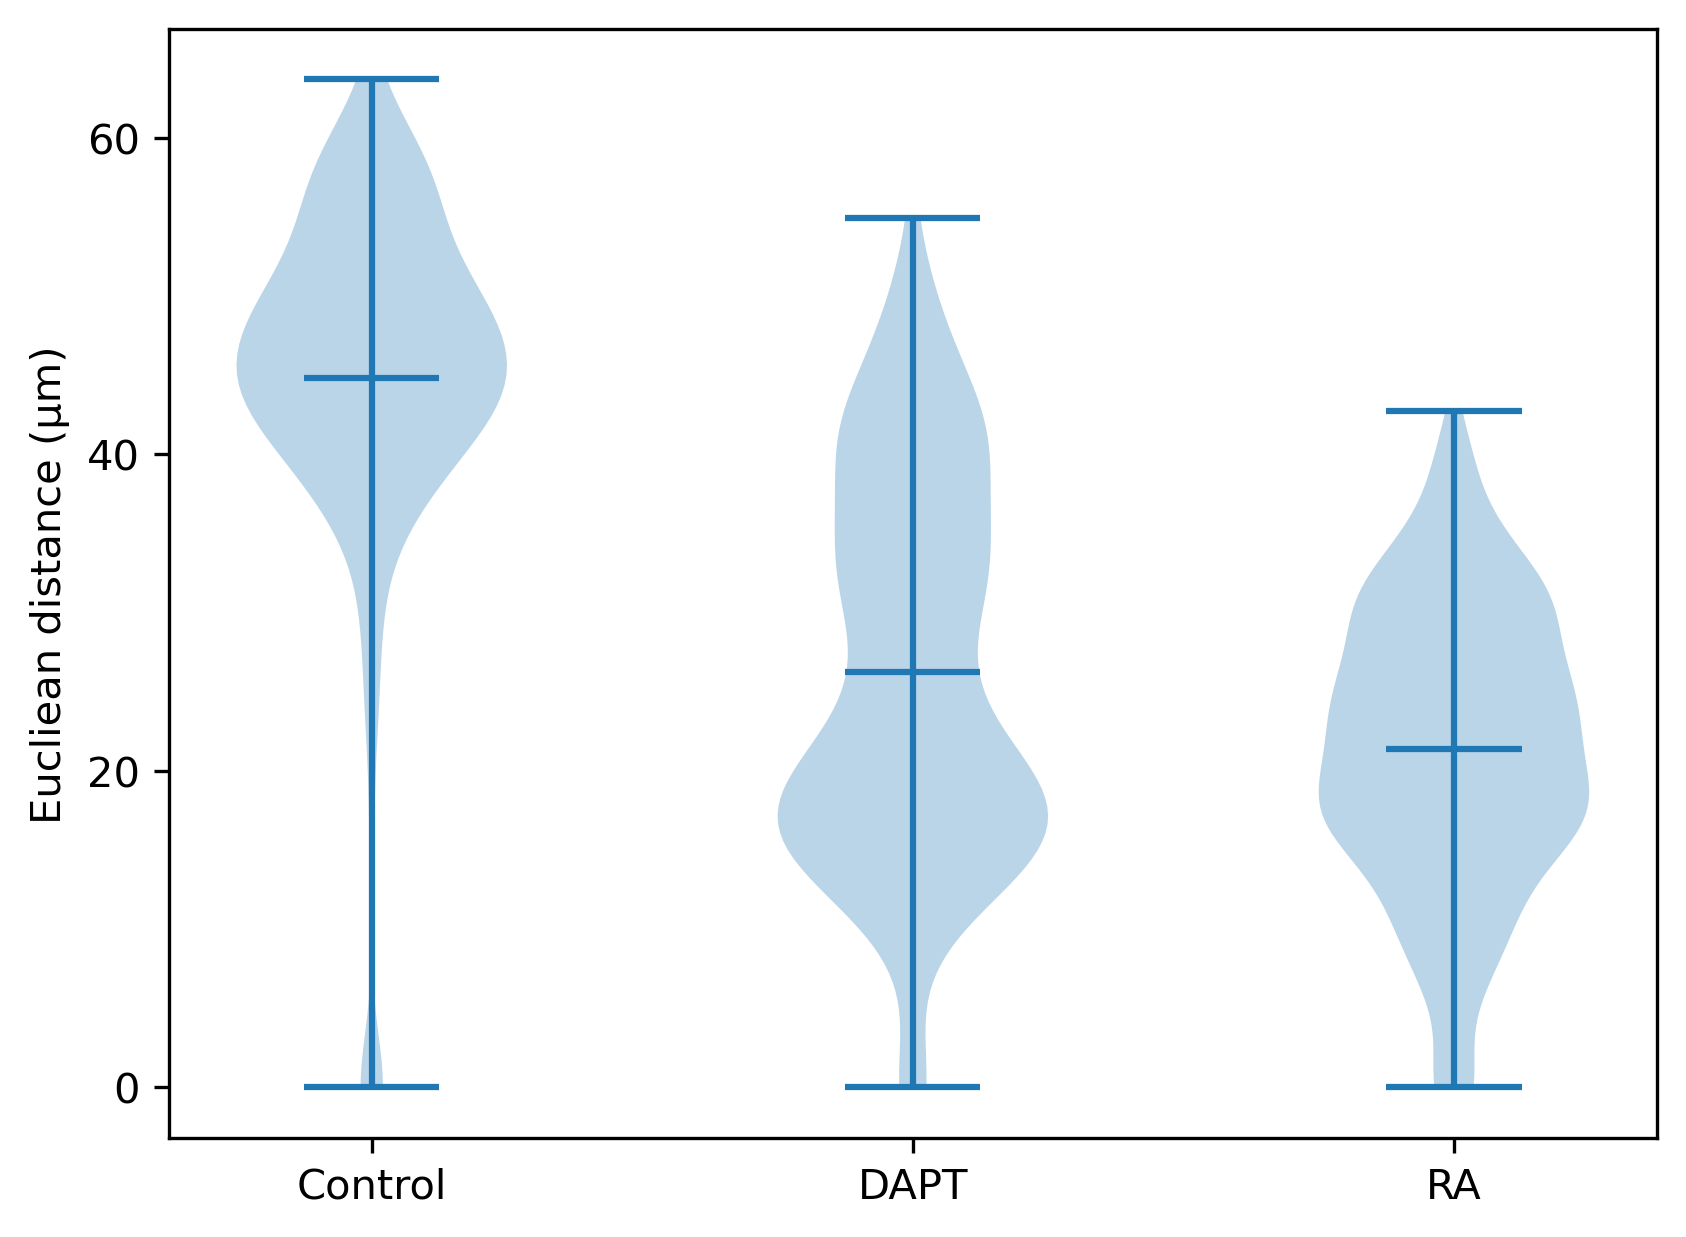

In [85]:
plt.figure(dpi=300)
plt.violinplot([euclidean_distance_control, euclidean_distance_DAPT, euclidean_distance_RA], showmeans=True)#, showmedians=True)

# Customize the plot
plt.xticks([1, 2, 3], ["Control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 20, 40, 60])
plt.ylabel("Eucliean distance (μm)")

### Persistence

In [80]:
def persistence(x_coords, y_coords): 

    # Euclidean Distance for each trajectory.
    start_end_distances = np.array([calculate_start_end_distance_pixel(x, y) for x, y in zip(x_coords, y_coords)])

    # Compute the length for each trajectory
    trajectory_lengths = np.array([calculate_trajectory_length_pixel(x, y) for x, y in zip(x_coords, y_coords)])

    # Persistence = Euclidean distance / trajectory length.  
    persistence = start_end_distances / trajectory_lengths
    # Filter out the NaN produced through deviding by 0. 
    persistence_filtered = persistence[~np.isnan(persistence)]

    return persistence_filtered 

In [81]:
persistence_control = persistence(x_coords_control, y_coords_control)
persistence_DAPT = persistence(x_coords_DAPT, y_coords_DAPT)
persistence_RA = persistence(x_coords_RA, y_coords_RA)

C:\Users\Rutian Zhou\AppData\Local\Temp\ipykernel_17532\3973531838.py:10: RuntimeWarning: invalid value encountered in divide
  persistence = start_end_distances / trajectory_lengths


Text(0, 0.5, 'Persistence')

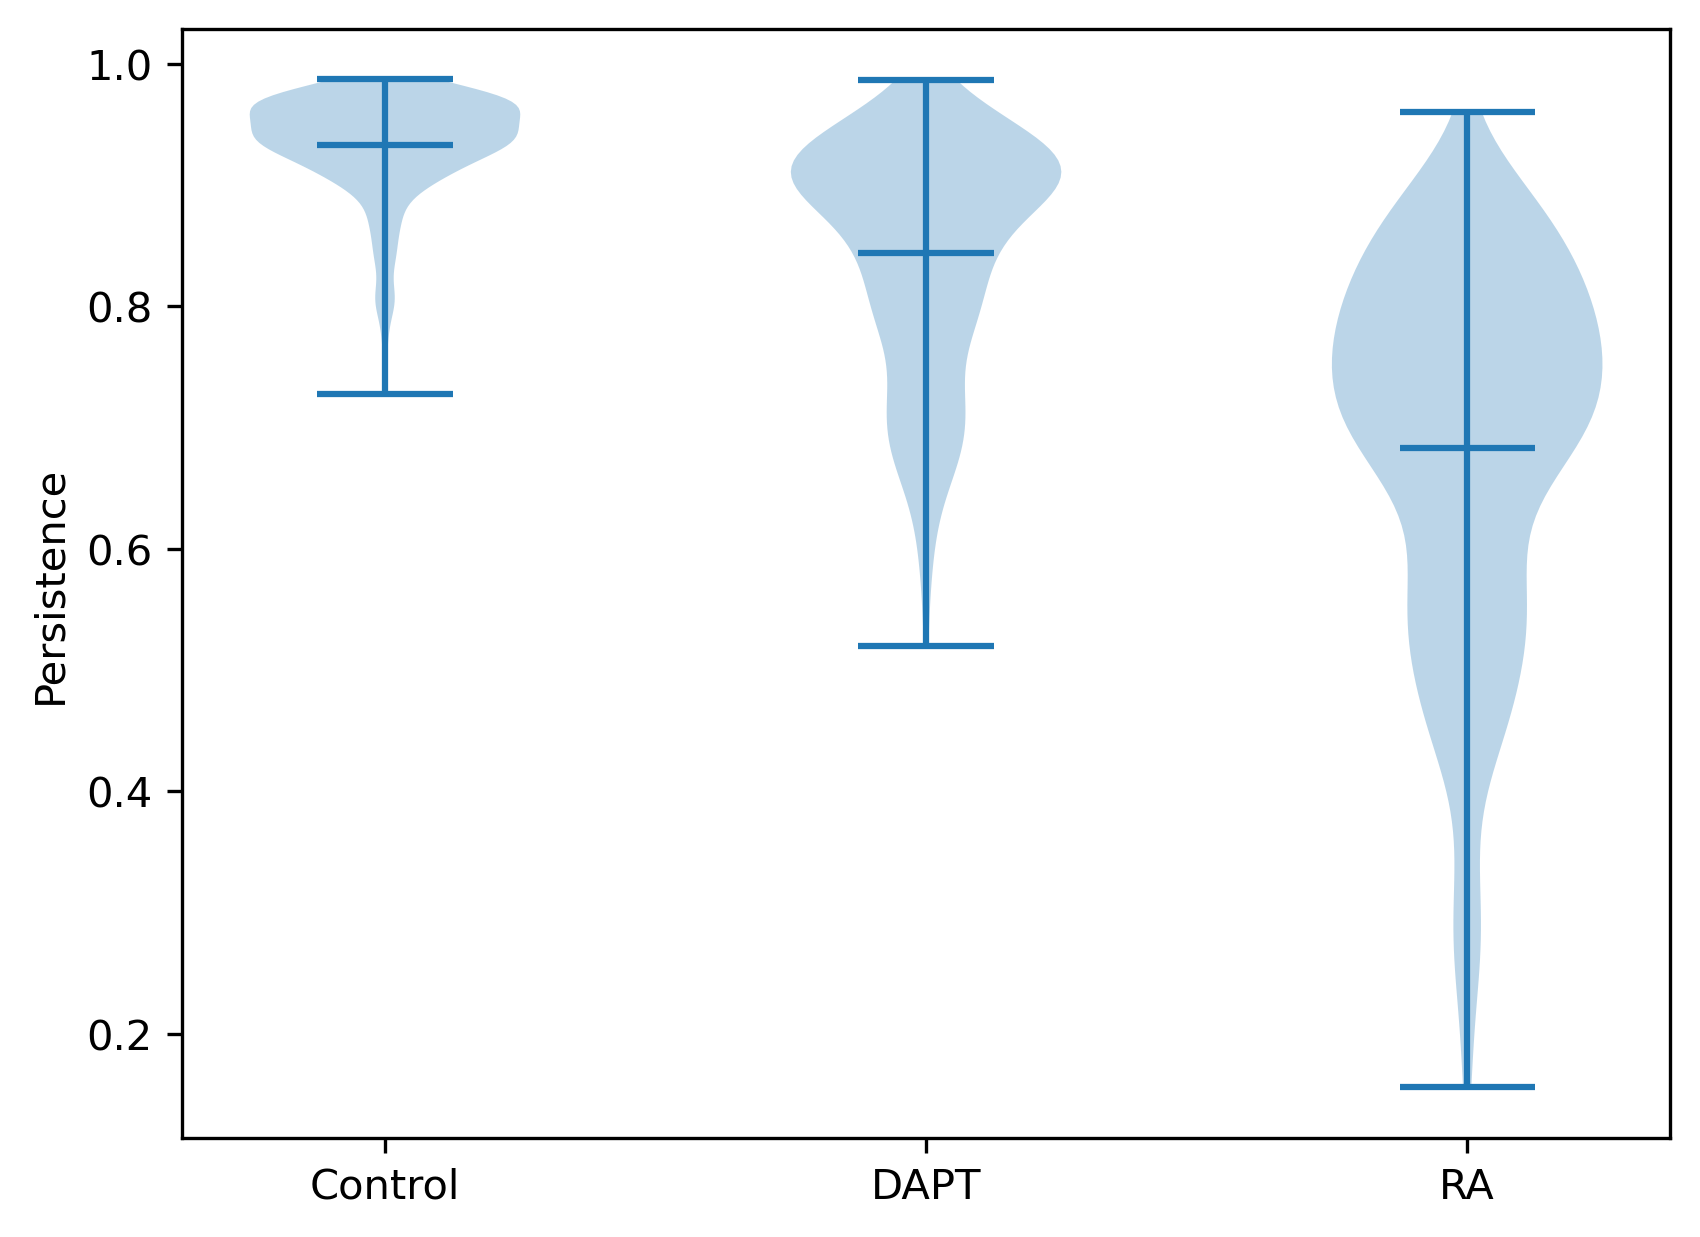

In [84]:
plt.figure(dpi=300)
plt.violinplot([persistence_control, persistence_DAPT, persistence_RA], showmeans=True)#, showmedians=True)

# Customize the plot
plt.xticks([1, 2, 3], ["Control", "DAPT", "RA"])  # Label each part
#plt.yticks([0, 20, 40, 60])
plt.ylabel("Persistence")